# Earthquake detection

The first step in the process of developing an earthquake catalog is to detect earthquakes.  The efficacy of the detection
system has a fundamental impact on the completeness of a given catalog: if you can't detect an earthquake, you can't do
anything else with it either.

## Brief history:
- Visual identification of earthquakes on drums;
- Triggered digital seismographs - usually triggered by energy detector
- Continuous data (due to the availability of large digital storage media), offline detection
    1. Energy detectors like STA/LTA
    2. similarity detectors
    3. machine learning

## What makes an earthquake different from noise?

To start off, lets think about how we would notice an earthquake in a seismogram. Key things to look out for are:
1. Amplitude change (but small earthquakes may fall below the noise level);
2. Frequency change (but then we miss low-frequency earthquakes...);
3. Polarization changes - P and S waves are polarized, noise should be random

Lets look at some of these changes in a seismic sequence.

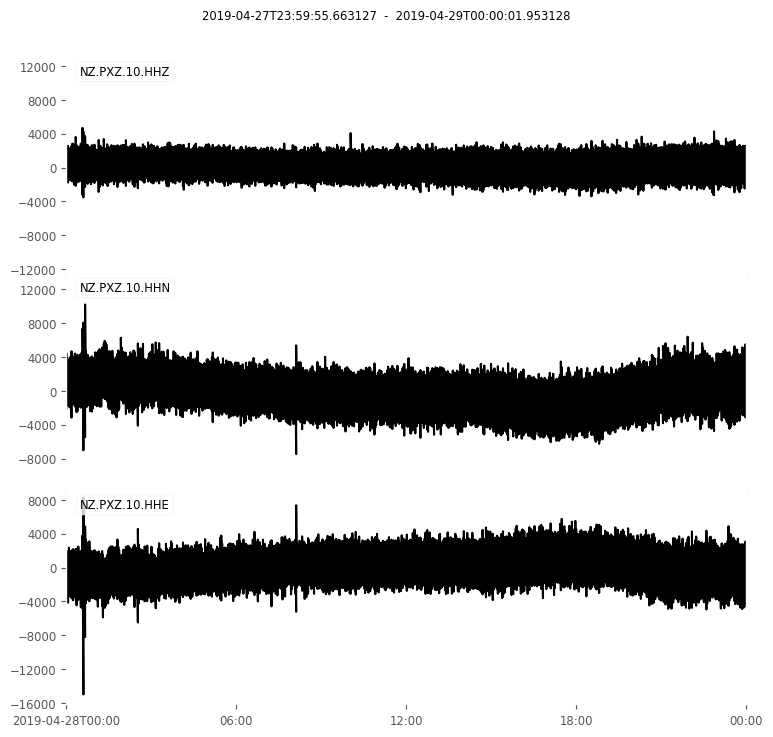

In [1]:
# Notebook set-up
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("GEONET")
starttime = UTCDateTime(2019, 4, 28)
endtime = starttime + 86400

st = client.get_waveforms(
    network="NZ", location="10", station="PXZ", channel="HH?",
    starttime=starttime, endtime=endtime)

st.plot()

The data we have downloaded are for a station near Porangahau - this region is prone to earthquake swarms, and the one we are going to look at here
appears to be associated with an ongoing slow-slip episode.  GeoNet has a number of earthquakes on this day, lets have a look at what they have close
to this station and see if we can detect them all.

GeoNet has 9 events between 2019-04-28T00:00:00.000000Z and 2019-04-29T00:00:00.000000Z in the region of interest


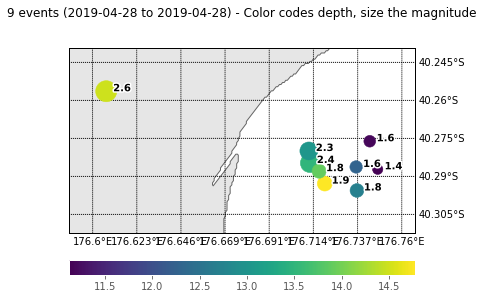

In [2]:
geonet_catalog = client.get_events(
    starttime=starttime, endtime=endtime,
    minlatitude=-40.406, maxlatitude=-40.137,
    minlongitude=176.588, maxlongitude=176.88)
print("GeoNet has {0} events between {1} and {2} in the region of interest".format(
    len(geonet_catalog), starttime, endtime))
fig = geonet_catalog.plot(projection="local", resolution="f")

Now that we have some data that we know is likely to contain earthquake waveforms, lets have a look at one of the earthquakes and see if
we can see the charactistics that differntiate it from noise. Lets pick the first earthquake in the catalog we downloaded for simplicity.

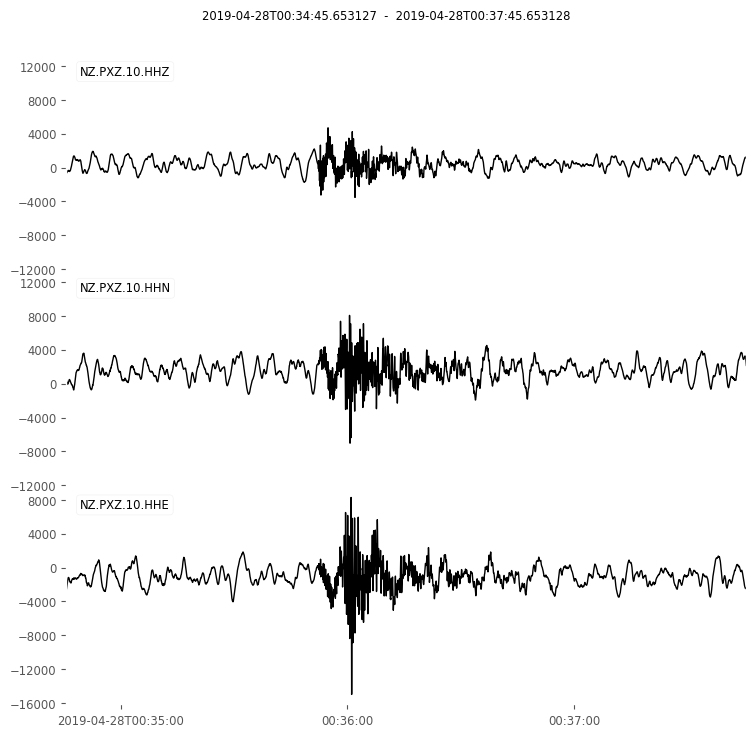

In [3]:
event = geonet_catalog[0]
# Trim the waveform around the event
event_st = st.slice(
    event.preferred_origin().time - 60,
    event.preferred_origin().time + 120).copy()
event_st.plot()

We can see there is a clear change in amplitude and frequency - we can also look at the spectrogram to see those changes.

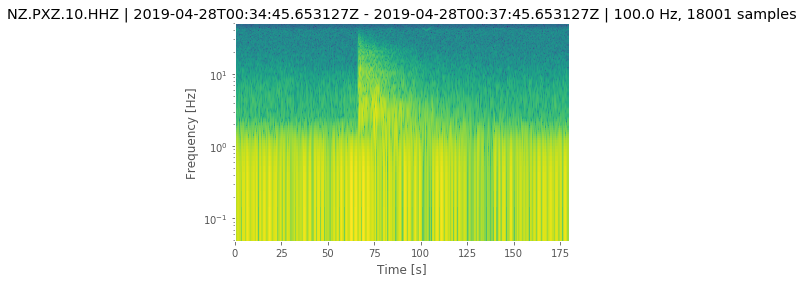

In [4]:
fig = event_st.select(component="Z").spectrogram(dbscale=True, log=True)

We can see that there is an increase in power above 2 Hz at the onset of the P-wave. We know that Earth's noise is dominant at low frequencies,
and we also know something about filtering.  Lets try highpassing the data to make the earthquake phases clearer. Remember that filtering
data changes the phase as well, so this will affect our estimation of when the earthquake phases arrive... Something to bear in mind when
looking at the [picking](2_Phase_Picking.ipynb) notebook.

/home/calumch/miniconda3/envs/gphs445/lib/python3.7/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


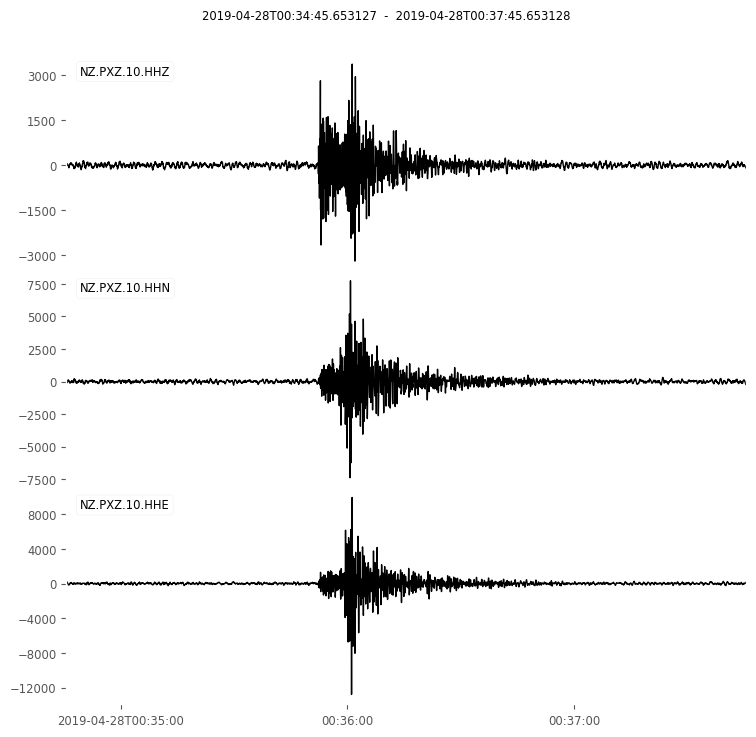

In [5]:
filtered = event_st.copy().detrend().filter("highpass", freq=1.5, corners=2)
fig = filtered.plot(equal_scale=False)

## Amplitude/energy detectors

One of the simplest ways to detect earthquakes is to look for high-amplitude waves and assume that these are earthquakes.
We will develop one of these detectors and use it for our data.  Because we do not know the noise-level of our data, and that
the noise level usually varies across stations and through time (night is usually quieter than day because of human activity,
storms often increase noise levels, amongst other factors), we will use a ratio of the short-term amplitude (STA) to the long-term
amplitude (LTA) to look for short duration increases in amplitude. This kind of detector is commonly termed an STA/LTA detector.

In [6]:
def moving_rms(a, n=3):
    """
    Compute the moving root-mean-square
    of a in windows of length n
    
    :type a: numpy.ndarray
    :type n: int
    """
    ret = np.cumsum(a ** 2, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return np.sqrt(ret[n - 1:] / n)


def sta_lta(tr, sta_len, lta_len):
    """
    Compute the STA/LTA ratio for a seismic trace
    
    :type tr: obspy.core.Trace
    :param tr: The trace to compute the STA/LTA for
    :type sta_len: float
    :param sta_len: Length of STA window in seconds
    :type lta_len: float
    :param lta_len: Length of LTA window in seconds
    
    :returns: numpy.ndarray of the detection statistic
    """
    n = tr.stats.npts
    lta_len_samples = int(round(lta_len * tr.stats.sampling_rate))
    sta_len_samples = int(round(sta_len * tr.stats.sampling_rate))
    if sta_len_samples * tr.stats.delta != sta_len:
        print("STA: {0} closest sample length is {1}".format(
            sta_len, sta_len_samples))
    if lta_len_samples * tr.stats.delta != lta_len:
        print("LTA: {0} closest sample length is {1}".format(
            lta_len, lta_len_samples))
    # lta starts one window length in to the trace
    lta = np.zeros(n)
    lta[lta_len_samples - 1:] =  moving_rms(
        a=tr.data, n=lta_len_samples)
    sta = np.zeros(n)
    sta[sta_len_samples - 1:] = moving_rms(
        a=tr.data, n=sta_len_samples)
    detector = np.zeros(n)
    detector[lta_len_samples - 1:] = sta[lta_len_samples - 1:] / lta[lta_len_samples - 1:]
    return detector


def plot_detector(tr, detector):
    """
    Plot the trace with the detection statistic overlaid
    
    :type tr: obspy.core.Trace
    :type detector: numpy.ndarray
    """
    from obspy import Stream
    st = Stream()
    st += tr
    detector_tr = tr.copy()
    detector_tr.data = detector
    detector_tr.stats.network = "STALTA"
    st += detector_tr
    fig = st.plot(equal_scale=False)
    return fig

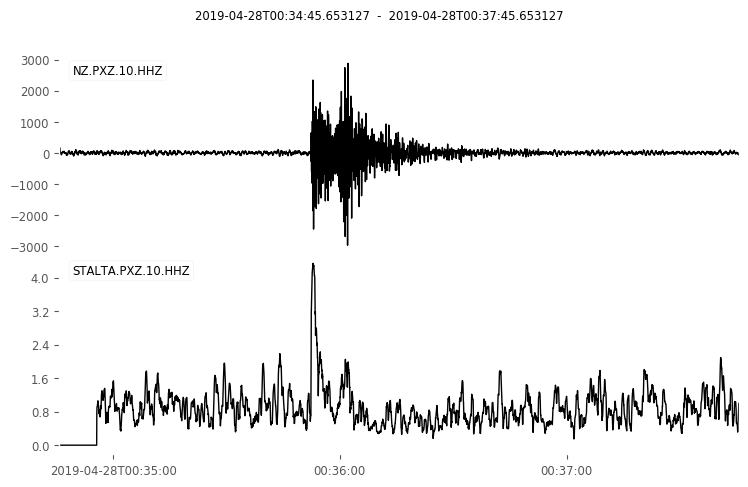

In [7]:
tr = event_st.select(component="Z")[0]
tr = tr.copy().filter("highpass", freq=2, corners=2)
detector = sta_lta(tr, 0.5, 10)
fig = plot_detector(tr, detector)

You can see that we get a peak in the STA/LTA ratio when the P-wave arrives. We would use that peak to generate an
alert or trigger.  Usually some threshold is set to turn the trigger on, and another threshold is set such that
no triggers are raised until the STA/LTA ratio drops beneath that level.  This second threshold is set to avoid
multiple triggers for the different phases of the earthquake waveform. However, this can mean that closely
spaced events are missed...

Play around with different STA and LTA lengths, a general rule of thumb is that your STA length should be similar 
to the duration of the impulsive P-arrival, and your LTA length should be long enough to capture a few wavelengths 
of you dominant low-frequency noise.

Try different filters as well, remember that filtering can be used to enhance signal and suppress noise, if
applied correctly!

In [9]:
# Try some different parameters here!

This is reasonably efficient, so we can easily apply this method to longer data streams.  Lets have a look at the
whole day of data and extract the detections and have a look at them! You can change the parameters to those that
you found to work well above.

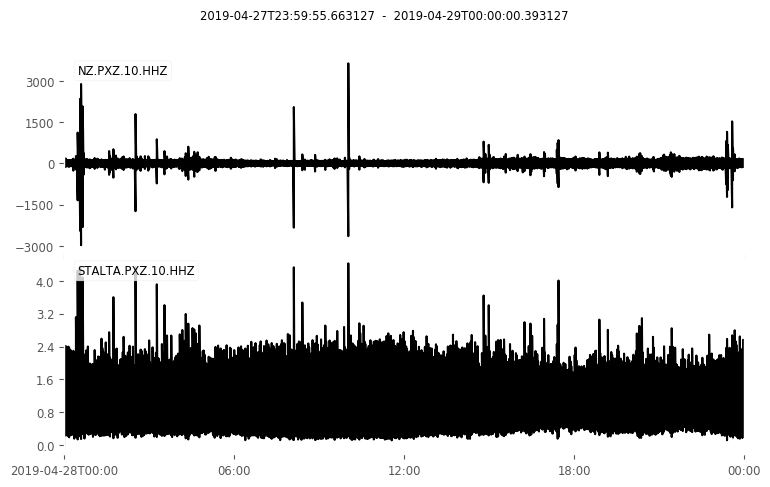

Found 7 peaks


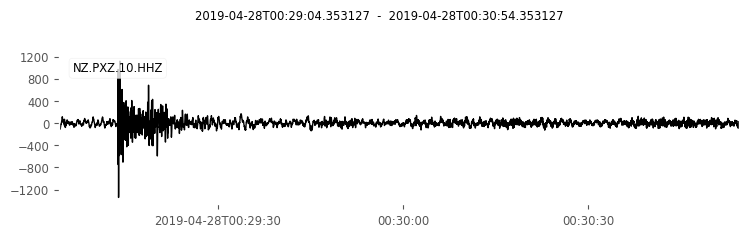

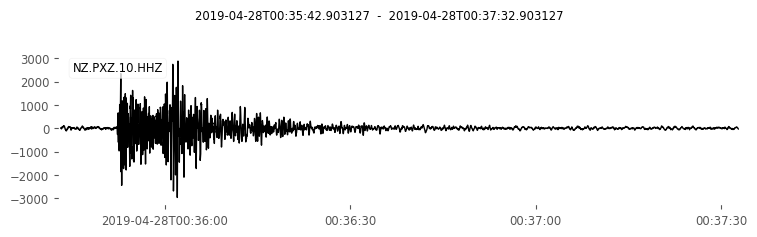

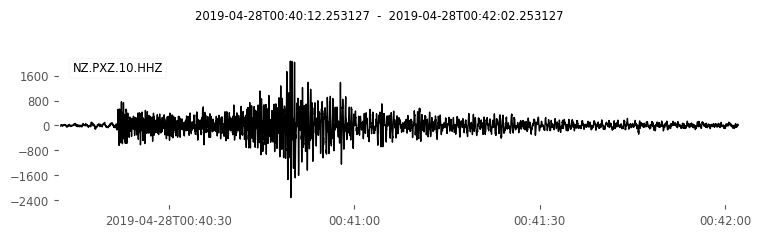

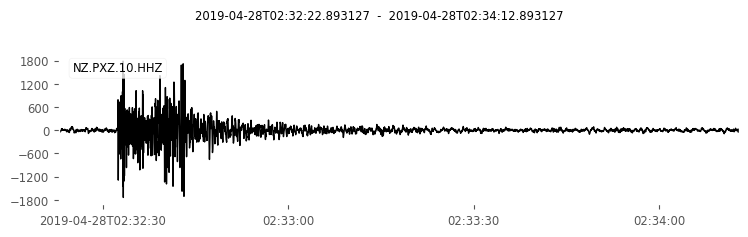

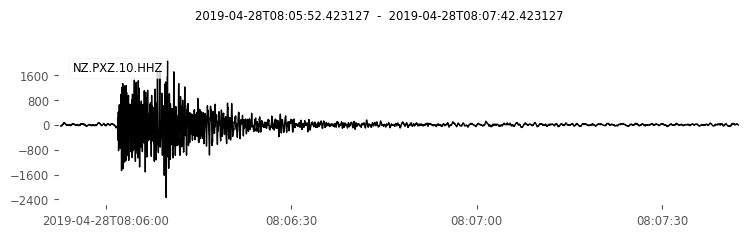

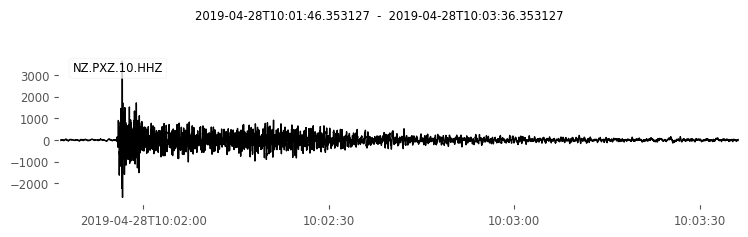

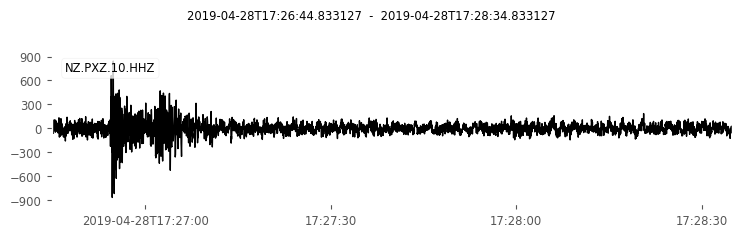

In [8]:
tr = st.select(component="Z")[0]
tr = tr.copy().filter("highpass", freq=2, corners=2)
detector = sta_lta(tr, 0.5, 10)
fig = plot_detector(tr, detector)

# Lets extract everything above some threshold
threshold = 4.0
trigger_off_time = 2.0  # We won't allow re-triggering for this
# time in seconds after a trigger.

# We will use the scipy function: find_peaks to find the highest values - note that this
# is likely to not correspond to the P-onset.
from scipy.signal import find_peaks

peaks, _ = find_peaks(
    detector, height=threshold, 
    distance=int(trigger_off_time * tr.stats.sampling_rate))

peak_times = [tr.stats.starttime + (peak * tr.stats.delta) for peak in peaks]
print("Found {0} peaks".format(len(peaks)))

def extract_detections(tr, detection_times, pre_detection=10, post_detection=100):
    detections = []
    for detection in detection_times:
        detections.append(
            tr.slice(detection - pre_detection, 
                     detection + post_detection).copy())
    return detections

detections = extract_detections(tr, peak_times)
for detection in detections:
    fig = detection.plot()

We can see that we can detect impulsive events, but so far we have only looked at a single station.  While this
can provide useful information, in general we need to see the waveforms on multiple stations to do anything useful
with the event (e.g. location). We also might have local noise sources like rockfalls, machinery, or lightning that
would raise a *false* trigger. To avoid these we can use a *coincidence triggering* routine. Obspy already has
a [coincidence triggering routine](https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html), as well
as various different trigger routines.

We will make use of their recursive STA/LTA routine (which incorporates a decay term to reduce the effect of impulsive
events on the LTA after they have happened). This produces a smoother characteristic function than the classic
STA/LTA (coded above). We will also use the Obspy coincidence trigger function to find detections that are shared
across a network of stations.

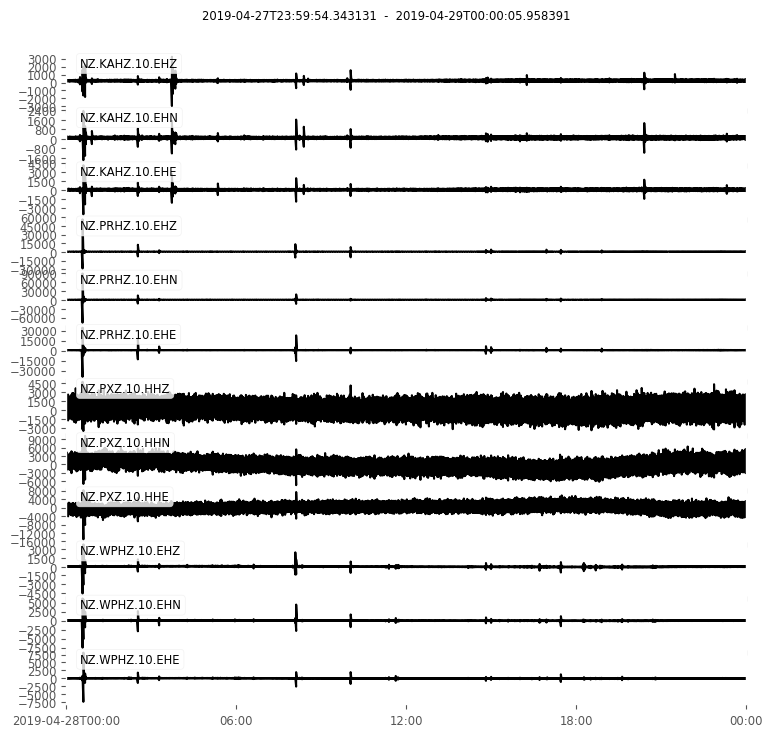

In [9]:
sta_chans = [('PXZ', 'HH?'), ('PRHZ', 'EH?'), ('KAHZ', 'EH?'),
             ('WPHZ', 'EH?')]
bulk = [("NZ", station, "10", channel, starttime, endtime) 
        for station, channel in sta_chans]
st = client.get_waveforms_bulk(bulk)
fig = st.plot(equal_scale=False, size=(800, 750))

In [10]:
from obspy.signal.trigger import coincidence_trigger

st.filter("highpass", freq=2, corners=2)
st2 = st.select(component="Z") # It is normal to just use the
# vertical channel, but not necessary.

# Generate a list of triggers: note that this does not use an
# explicit re-triggering time limit, rather it uses a secondary
# threshold as discussed above.
# This will make detections only if a detection occurs on at-least
# 3 stations (set by thr_coincidence_sum)
trig = coincidence_trigger(
    "recstalta", thr_on=7.0, thr_off=1, 
    stream=st2, thr_coincidence_sum=3, sta=0.5, lta=10)
print("Found {0} triggers".format(len(trig)))

Found 14 triggers


Lets extract each detection on station PXZ, channel HHZ and look at them.

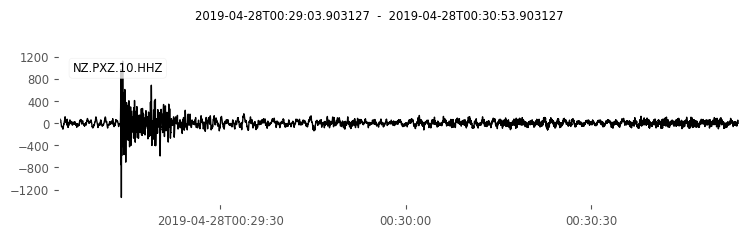

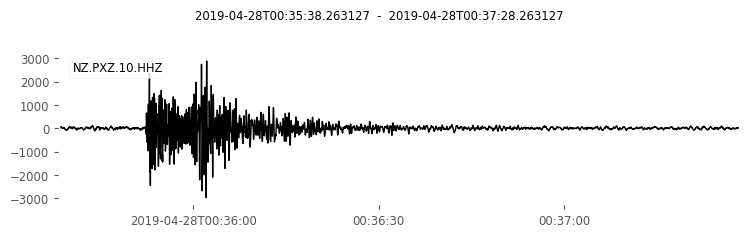

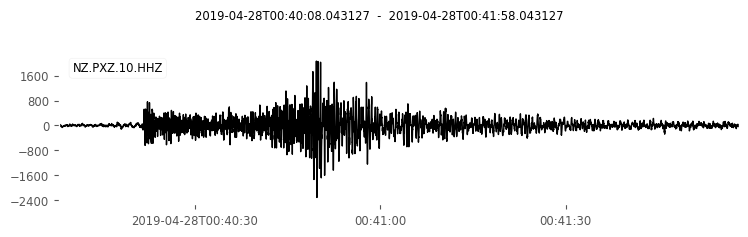

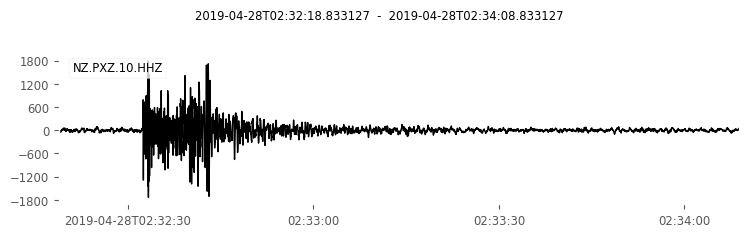

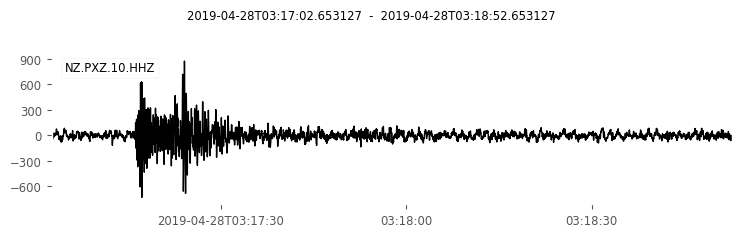

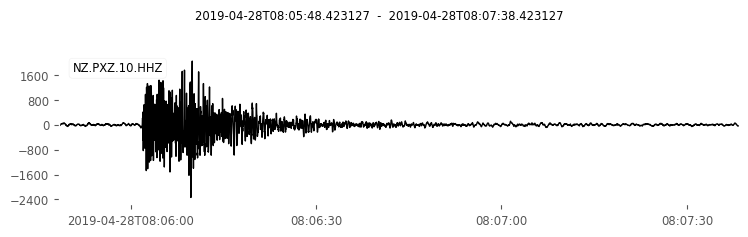

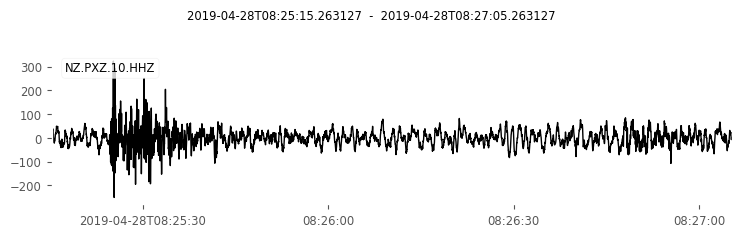

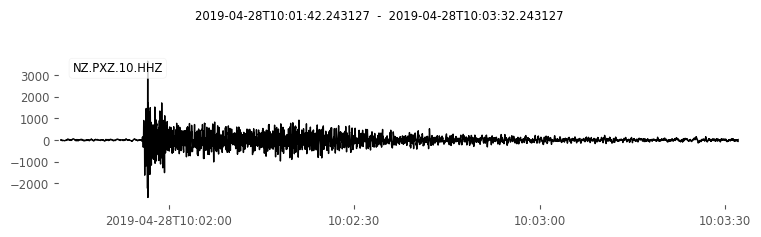

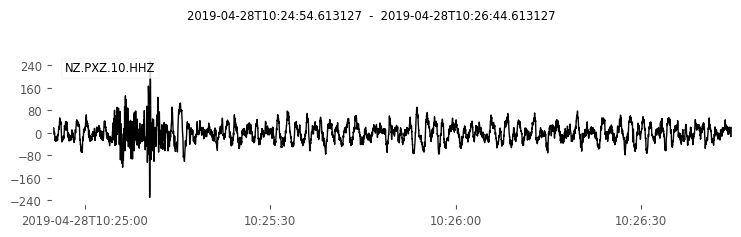

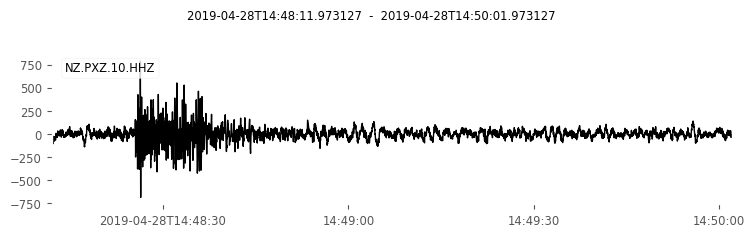

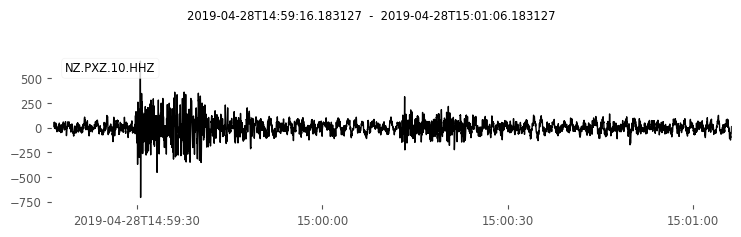

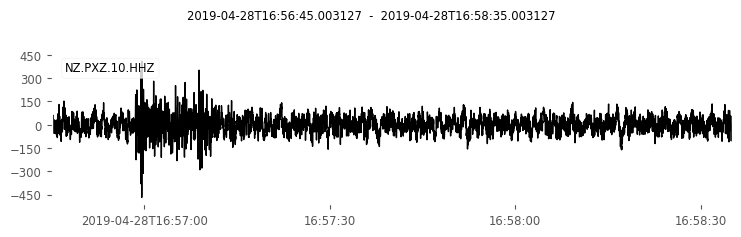

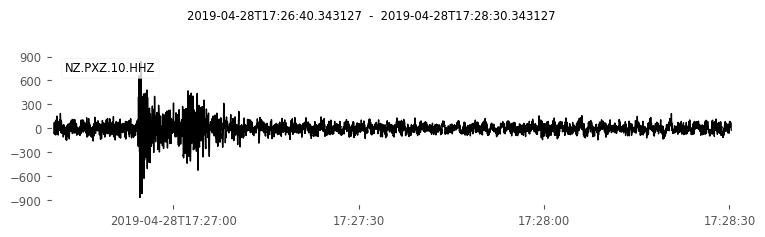

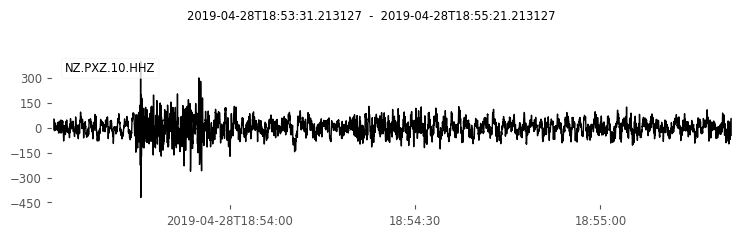

In [11]:
tr = st.select(station="PXZ", component="Z")[0]
detections = extract_detections(tr, [t['time'] for t in trig])
for detection in detections:
    fig = detection.plot()

Clearly there are lots of impulsive events in this day, probably more than GeoNet has in it's catalogue.  You can play with the
parameters above and see what the thresholds do to the number of detections you make.

It is common to take a list of detections from such a routine and then use an automatic picker, or to manually pick
the phases to determine which triggers are real and of interest, and which can be ignored.  For GeoNet, they use an
automatic picker, followed by manual evaluation of quality.  GeoNet often will not include events with fewer than
10 picks in its catalogue, which effectively limits the magnitude of completeness of the catalogue (the magnitude
above which all events are thought to be included in the catalogue). This often means that, with careful analysis,
many more earthquakes can be detected than are in the national catalogue.  Furthermore, by useing data from additional
stations, we can build an even more detailled picture of the seismicity in a region.

## Matched-filter detection

You will have noticed that lots of the earthquakes we detected above come from a similar location and have similar waveforms.
When earthquakes waveforms are similar we can exploit this similarity for detection: we can use correlation between a template
waveform and the continuous data to generate a charataristic function, and detect using that. This has a few advantages:
1. Correlation detectors are not as sensitive to noise amplitudes as energy (e.g. STA/LTA) detectors, so they
   can detect low signal-to-noise ratio events;
2. Correlation detectors do not require amplitudes to return to low levels, meaning that multiple events that
   occur close in time can be detected
   
However, similarity detectors have some major disadvatages:
1. You can only detect things that you have seen before - you need a template event;
2. This limits you to events close in space ad with similar focal mechanisms.

This means that similarity detectors are relaly useful for swarms and aftershock sequences, but are less well suited
to detecting background seismicity.

Lets develop a simple, single-channel matched-filter for our swarm.  We will start by extracting the waveforms for
the events in the GeoNet catalog, then we will correlate these with the continous data.

/home/calumch/miniconda3/envs/gphs445/lib/python3.7/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


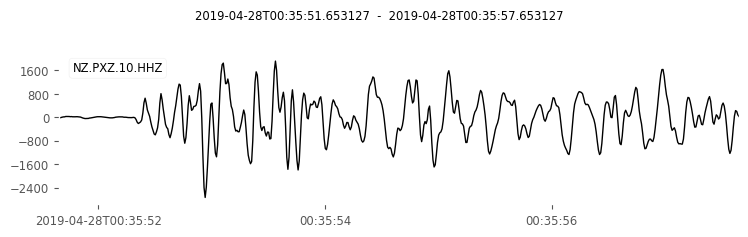

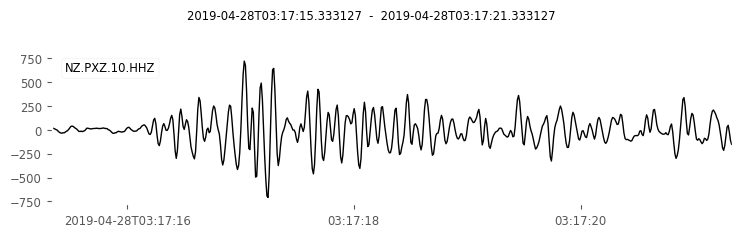

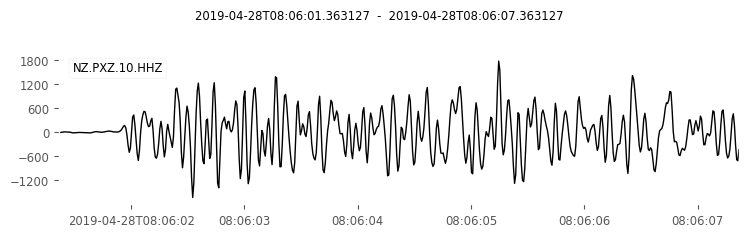

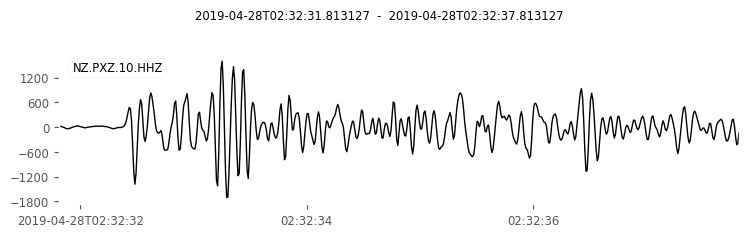

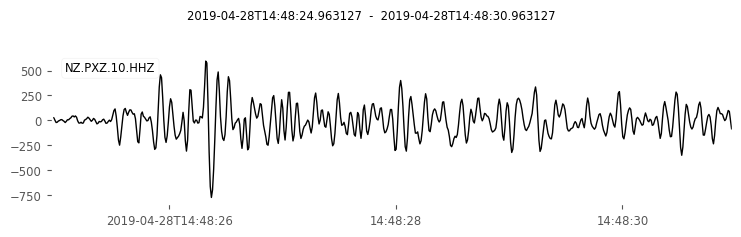

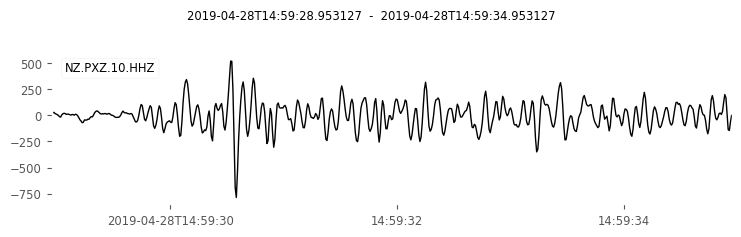

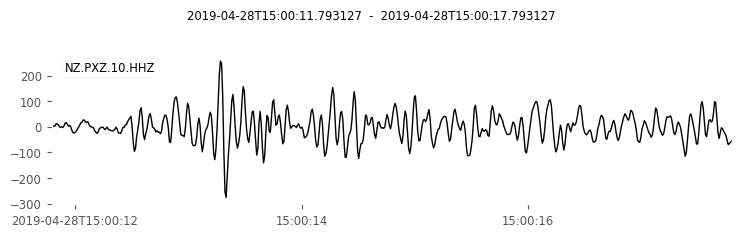

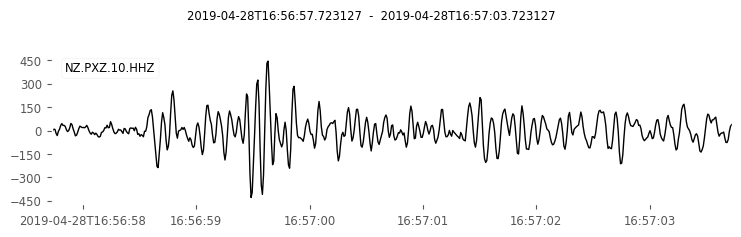

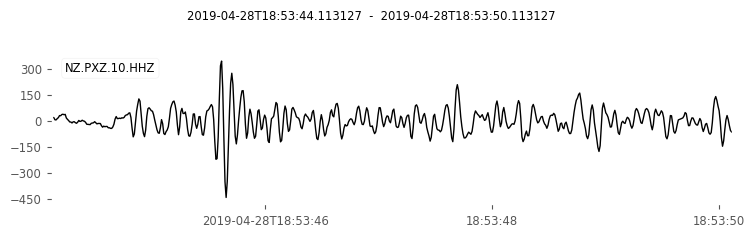

In [12]:
tr = st.select(station="PXZ", component="Z")[0]
filtered = tr.copy().detrend().filter("highpass", freq=2, corners=2)
geonet_times = [e.preferred_origin().time for e in geonet_catalog]
templates = extract_detections(
    tr=filtered, detection_times=geonet_times, pre_detection=-6, 
    post_detection=12)
for template in templates:
    fig = template.plot()

For the correlations we will use Obspy's correlation functions - there are also options in obspy for multi-channel
templates.  Other packages (including [EQcorrscan](https://eqcorrscan.readthedocs.io/en/latest/) and 
[FastMatchedFilter](https://github.com/beridel/fast_matched_filter)) have been developed to compute
matched-filter detections as well, and are often faster.

Made 22 detections from 9 templates
Made 14 detections after declustering


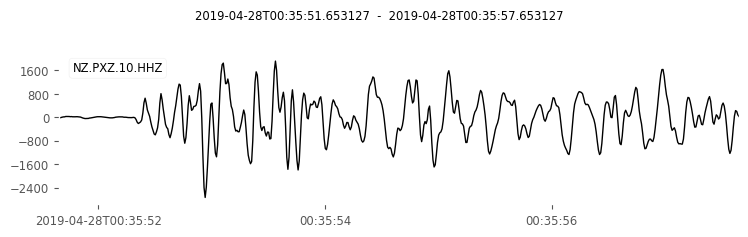

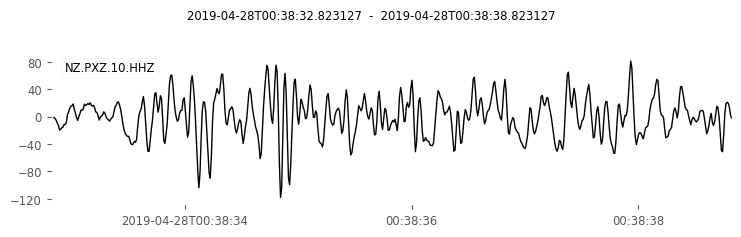

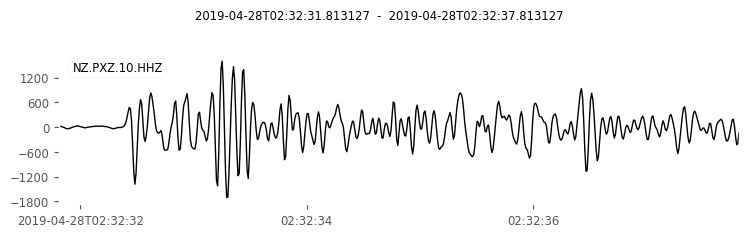

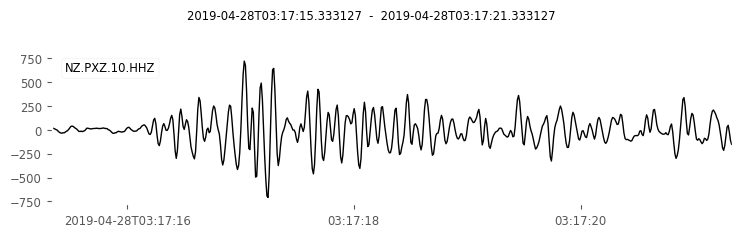

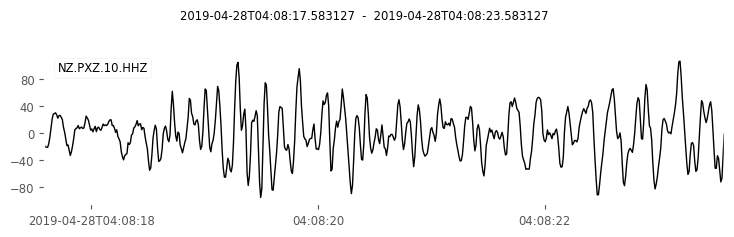

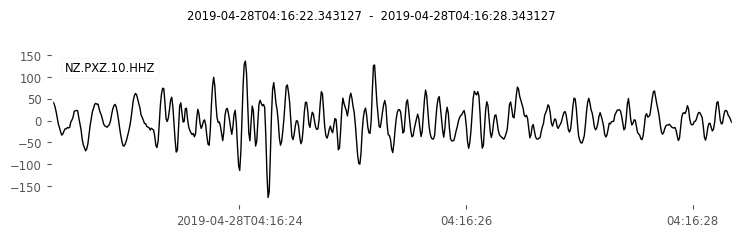

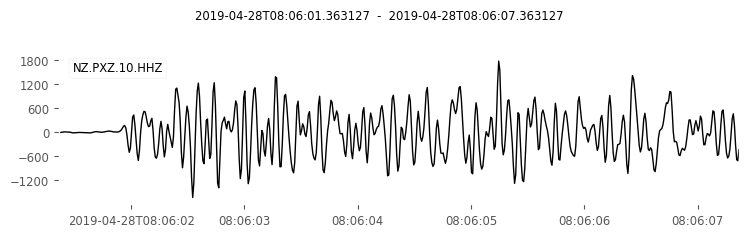

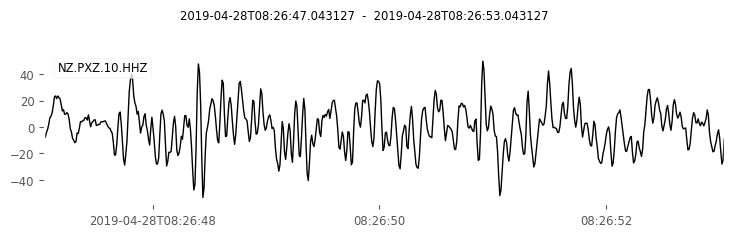

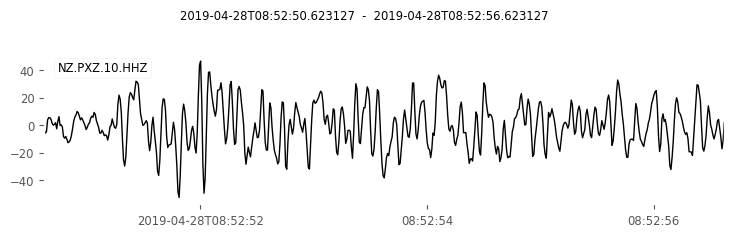

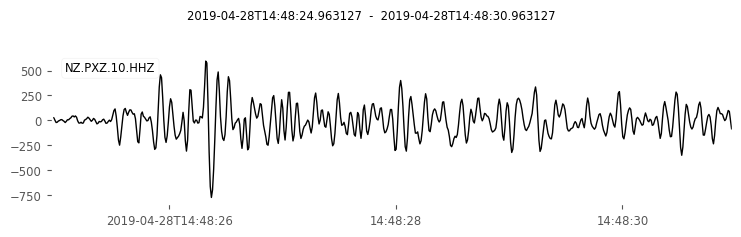

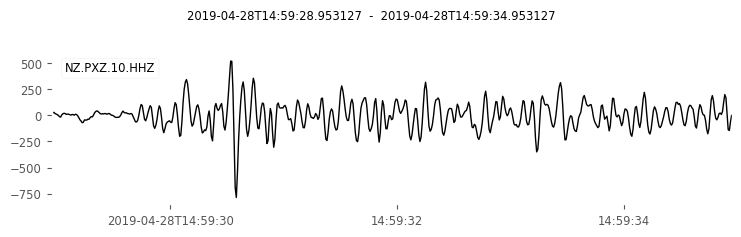

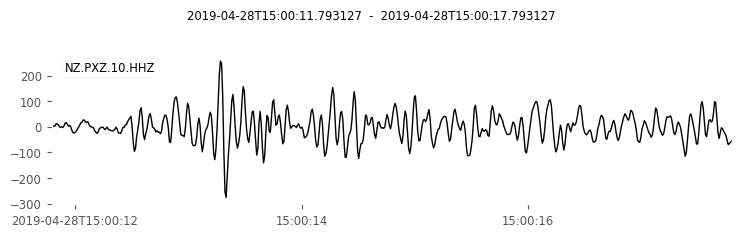

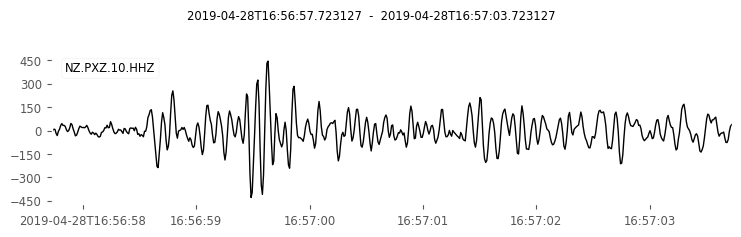

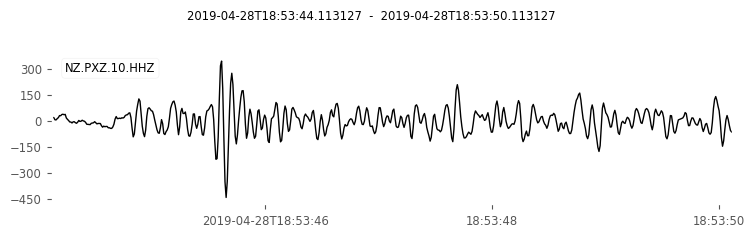

In [13]:
from correlate_template import correlate_template

threshold = 0.5  # Normalised correlations lie in the range -1.0 -- 1.0
trig_off_time = 2.0

peaks, values = ([], [])
for template in templates:
    xcorr = correlate_template(data=filtered, template=template)
    _peaks, _values = find_peaks(
        xcorr, height=threshold, 
        distance=trig_off_time * filtered.stats.sampling_rate)
    peaks.extend(_peaks)
    values.extend(_values['peak_heights'])
print("Made {0} detections from {1} templates".format(
    len(peaks), len(templates)))

# There are some duplicate detections in the list, we should remove those
sorted_detections = sorted(zip(peaks, values), reverse=True)
to_decluster = np.zeros(sorted_detections[0][0] + 1)
for location, value in sorted_detections:
    to_decluster[location] = value
detections, _ = find_peaks(
    to_decluster, height=threshold,
    distance=trig_off_time * filtered.stats.sampling_rate)
print("Made {0} detections after declustering".format(
    len(detections)))

detection_waveforms = extract_detections(
    tr=filtered, pre_detection=0, post_detection=6,
    detection_times=[filtered.stats.starttime + (d * filtered.stats.delta) for d in detections])
for d in detection_waveforms:
    fig = d.plot()

All detections look like earthquakes.  We could lower the threshold and make more detections, however we would be
better off extending to multiple stations.  For a demonstration of the efficacy of matched-filters to earthquake detection,
see the paper by [Warren-Smith et al. (2017)](https://pubs.geoscienceworld.org/ssa/srl/article/88/4/1065/354127/high-precision-analysis-of-an-aftershock-sequence).
This also documents a nice extension from detection to re-picking that then enables high-precision relocations to be computed
to study structures.  This is definitely recommended reading!

## Machine learning

Recent advances in machine learning have led to novel earthquake detection methods. 
A [recent review paper](https://pubs.geoscienceworld.org/ssa/srl/article/90/1/3/566430/machine-learning-in-seismology-turning-data-into)
is worth a read to see how modern computational methods are being applied to earthquake detection and
characterization problems.